In [48]:
import sys ; sys.path.insert(0, "..")

from collections import defaultdict
from src.graphs import DeBruijnGraph

In [49]:
seq = "TAATGCCATGGGATGTT"
k   =  2
kmer_count = defaultdict(int)
for pos in range(len(seq)-k+1):
    kmer = seq[pos:pos+k]
    kmer_count[kmer] += 1
    

In [50]:
kmer_count

defaultdict(int,
            {'TA': 1,
             'AA': 1,
             'AT': 3,
             'TG': 3,
             'GC': 1,
             'CC': 1,
             'CA': 1,
             'GG': 2,
             'GA': 1,
             'GT': 1,
             'TT': 1})

In [38]:
dbg = DeBruijnGraph(sequence=seq, k=k)

From sequence


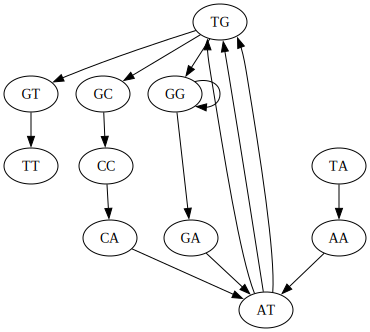

In [39]:
dbg.show()

In [24]:
dbg.edges

[('TA', 'AA'),
 ('AA', 'AT'),
 ('AT', 'TG'),
 ('TG', 'GC'),
 ('GC', 'CC'),
 ('CC', 'CA'),
 ('CA', 'AT'),
 ('AT', 'TG'),
 ('TG', 'GG'),
 ('GG', 'GG'),
 ('GG', 'GA'),
 ('GA', 'AT'),
 ('AT', 'TG'),
 ('TG', 'GT'),
 ('GT', 'TT')]

In [25]:
dbg.nodes

{'AA', 'AT', 'CA', 'CC', 'GA', 'GC', 'GG', 'GT', 'TA', 'TG', 'TT'}

___
### torch dBG loader


In [43]:
import torch
from torch_geometric.data import Data

In [53]:
idx_nodes = {kmer: idx  for idx, kmer in  enumerate(dbg.nodes)}
idx_nodes

{'TG': 0,
 'GT': 1,
 'AA': 2,
 'CC': 3,
 'TT': 4,
 'TA': 5,
 'AT': 6,
 'GA': 7,
 'GC': 8,
 'CA': 9,
 'GG': 10}

In [45]:
edges =  list(map( lambda x: (idx_nodes[x[0]],idx_nodes[x[1]]) , dbg.edges))
edges

[(5, 2),
 (2, 6),
 (6, 0),
 (0, 8),
 (8, 3),
 (3, 9),
 (9, 6),
 (6, 0),
 (0, 10),
 (10, 10),
 (10, 7),
 (7, 6),
 (6, 0),
 (0, 1),
 (1, 4)]

In [47]:
# edges as torch tensors
edge_index = torch.tensor(edges, dtype=torch.long)

In [58]:
# node features (kmer frequencies)
feat_nodes = [ [kmer_count[kmer]] for kmer in dbg.nodes]
x = torch.tensor(feat_nodes, dtype=torch.float)
x

tensor([[3.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.]])

In [59]:
data = Data(x=x, edge_index=edge_index.t().contiguous())

In [60]:
data

Data(x=[11, 1], edge_index=[2, 15])

In [61]:
data.validate(raise_on_error=True)

True

In [62]:
data.keys()

['edge_index', 'x']

In [63]:
data["x"]

tensor([[3.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.]])

In [64]:
data["edge_index"]

tensor([[ 5,  2,  6,  0,  8,  3,  9,  6,  0, 10, 10,  7,  6,  0,  1],
        [ 2,  6,  0,  8,  3,  9,  6,  0, 10, 10,  7,  6,  0,  1,  4]])

In [65]:
data.has_self_loops()

True

In [67]:
data.is_directed()

True

___
### DataLoader

In [68]:
from torch_geometric.loader import DataLoader

In [71]:
data_list = [data, data, data, data, data]
loader = DataLoader(data_list, batch_size=2)

In [72]:
for batch in loader:
    print(batch)

DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[22, 1], edge_index=[2, 30], batch=[22], ptr=[3])
DataBatch(x=[11, 1], edge_index=[2, 15], batch=[11], ptr=[2])
